In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, sys
import xarray as xr

# check initial sampling

In [2]:
nparam = 13
params = np.nan * np.zeros([400, nparam])

for i in range(400):
    file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/MOASMO_exps/level1_221_exp2/param_sets/paramset_iter0_trial{i}.pkl'
    df = pd.read_pickle(file)
    va = df['Value'].values
    for j in range(nparam):
        params[i, j]=np.nanmean(va[j])

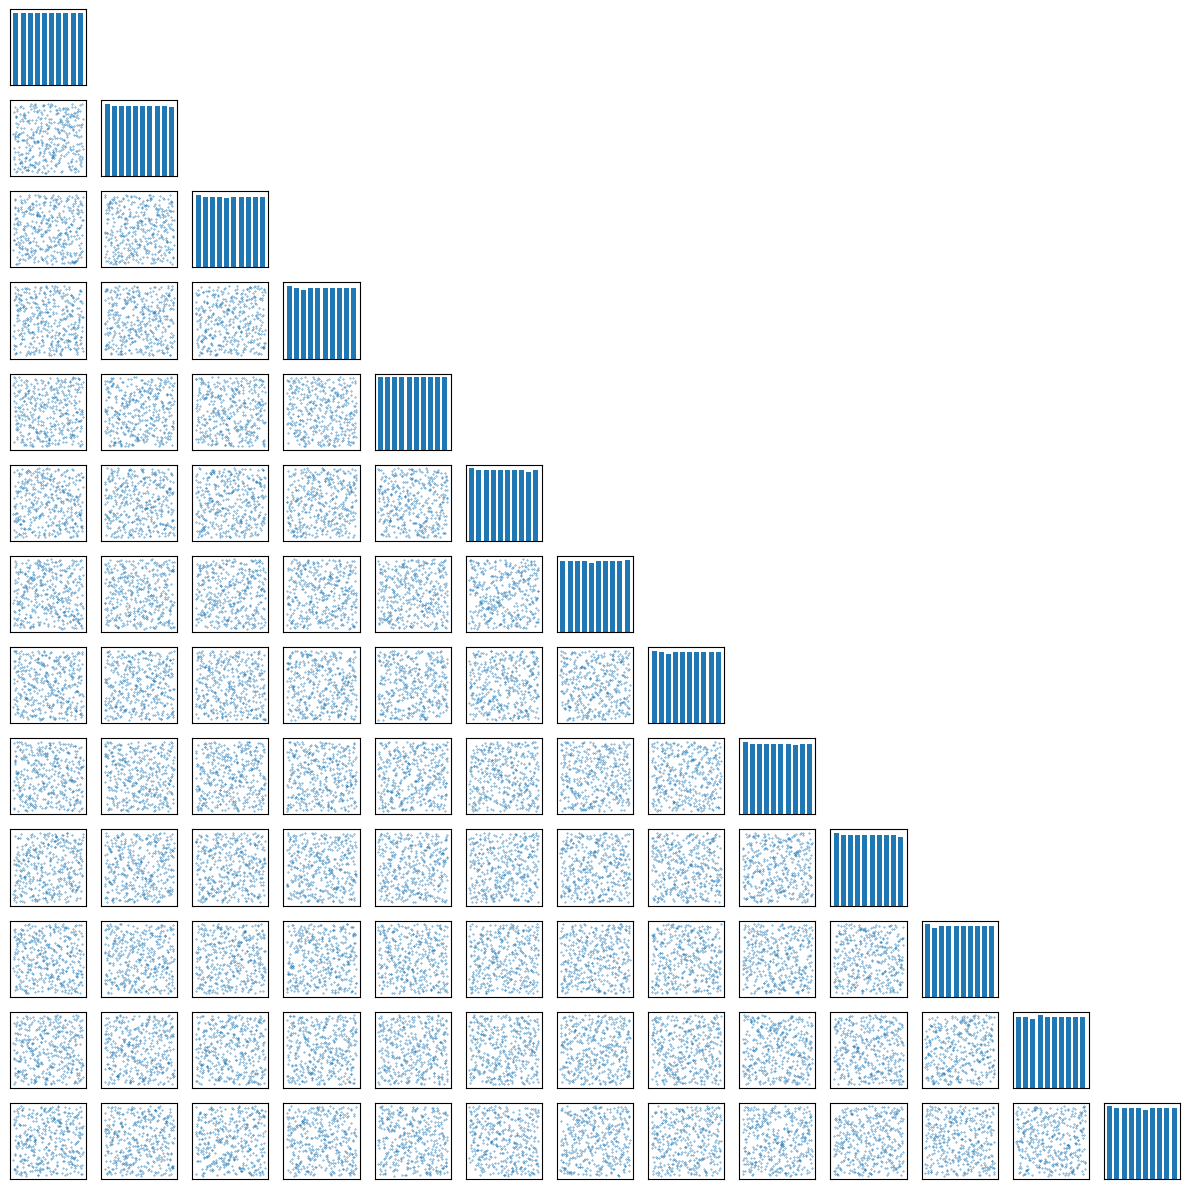

In [3]:
fig, axs = plt.subplots(nparam, nparam, figsize=[12, 12])

for i in range(nparam):
    for j in range(nparam):
        ax = axs[i, j]
        
        if j>i:
            ax.axis('off')
            
        elif j==i:
            ax.hist(params[:,i], rwidth=0.7)
            
            # Hide X and Y axes label marks
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)

            # Hide X and Y axes tick marks
            ax.set_xticks([])
            ax.set_yticks([])
            
        else:
        
            ax.scatter(params[:,i], params[:,j], 0.1)

            # Hide X and Y axes label marks
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)

            # Hide X and Y axes tick marks
            ax.set_xticks([])
            ax.set_yticks([])
        
plt.tight_layout()
plt.show()

In [8]:
print(np.nanmin(params,axis=0))
print(np.nanmax(params,axis=0))

[1.010000e-01 2.599875e-02 1.123750e-01 1.123750e-01 1.248750e-01
 1.123750e-01 1.011250e-01 9.748750e-05 1.248750e-09 1.373750e-03
 1.248750e-01 1.073750e+00 1.123750e-03]
[8.99000000e-01 1.99750013e+01 9.98762500e+00 9.98762500e+00
 1.99751250e+01 9.98762500e+00 1.00000000e+00 6.99125125e-02
 1.99751250e-07 2.99626250e-01 1.99751250e+01 5.99262500e+01
 9.98762500e-02]


# compare streamflow

In [9]:

def read_CAMELS_Q(file_Qobs):
    df_q_in = pd.read_csv(file_Qobs, delim_whitespace=True, header=None)
    years = df_q_in[1].values
    months = df_q_in[2].values
    days = df_q_in[3].values
    dates = [f'{years[i]}-{months[i]:02}-{days[i]:02}' for i in range(len(years))]
    dates = pd.to_datetime(dates)
    q_obs = df_q_in[4].values * 0.028316847  # cfs to cms
    q_obs[q_obs < 0] = -9999.0
    df_q_out = pd.DataFrame({'Date': dates, 'Runoff_cms': q_obs})
    
    # fill possible missing values
    df_q_out.set_index('Date', inplace=True)
    date_range = pd.date_range(start=dates[0], end=dates[-1], freq='D')
    df_q_out = df_q_out.reindex(date_range)
    df_q_out.fillna(-9999, inplace=True)
    df_q_out.reset_index(inplace=True)
    df_q_out = df_q_out.rename(columns={'index': 'Date'})

    return df_q_out

file = "/glade/work/guoqiang/CTSM_CAMELS/CAMLES_Qobs/03384450_streamflow_qc.txt"
df_obs = read_CAMELS_Q(file)

ds_obs = xr.Dataset()
ds_obs.coords['time'] = pd.to_datetime(df_obs['Date'].values)
ds_obs['Runoff_cms'] = xr.DataArray(df_obs['Runoff_cms'].values, dims=['time']) # flexible time

In [10]:
n = 221
ds_surf = xr.load_dataset('/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/sfcdata/surfdata_CAMELS_level1_hist_78pfts_CMIP6_simyr2000_HAND_trapezoidal.nc')
area = ds_surf.AREA.isel(gridcell=n).values

In [50]:
# priori Q
files = glob.glob(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/MOASMO_exps/level1_221_exp2/ctsm_outputs/iter0_trial0/lnd/hist/*h1*nc')
files.sort()
ds_simu_priori = xr.open_mfdataset(files)
ds_simu_priori['time'] = ds_simu_priori.indexes['time'].to_datetimeindex()
ds_simu_priori['QRUNOFF2'] = (ds_simu_priori['QRUNOFF'] / 1000) * (area * 1e6)
ds_simu_priori = ds_simu_priori.isel(time=slice(365,-1)) # ignore first year

/glade/derecho/scratch/guoqiang/tmp/ipykernel_3082/2594655383.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_simu_priori['time'] = ds_simu_priori.indexes['time'].to_datetimeindex()


In [51]:
# same time
ds_obs = ds_obs.sel(time=ds_obs.time.isin(ds_simu_priori.time))
ds_simu_priori = ds_simu_priori.sel(time=ds_simu_priori.time.isin(ds_obs.time))

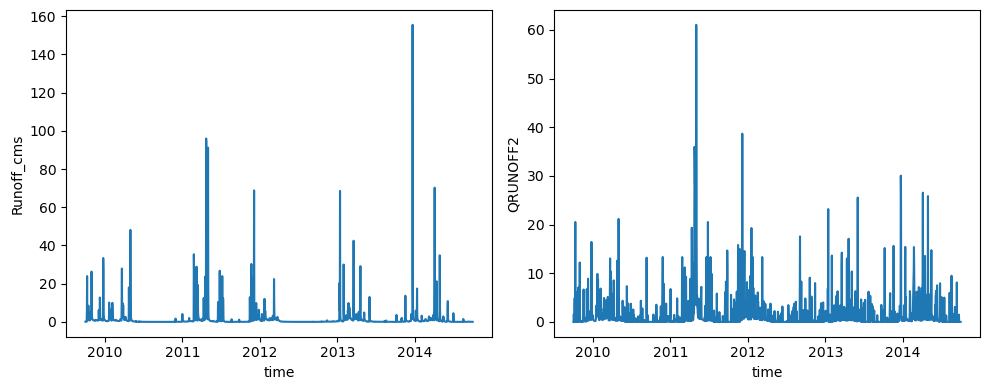

In [57]:
fig, axs = plt.subplots(1,2,figsize=[10, 4])

ds_obs.Runoff_cms.plot(ax=axs[0],label='Obs')
ds_simu_priori.QRUNOFF2.plot(ax=axs[1],label='priori')
plt.tight_layout()
plt.show()

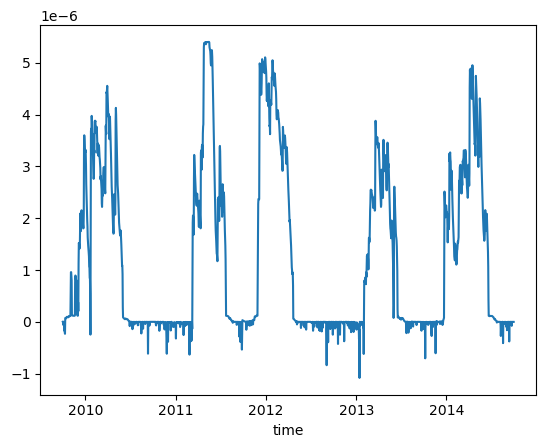

In [60]:
# ds_simu_priori.QOVER.plot(label='over')
# ds_simu_priori.QINFL.plot(label='infi')
# plt.legend()
diff = ds_simu_priori.QRUNOFF - ds_simu_priori.QOVER
diff.plot()

# Check iter-0 results

In [4]:
df_met0 = pd.read_csv('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/MOASMO_exps/level1_221_exp2/ctsm_outputs_normKGE/iter0_many_metric.csv')


0.3181109467195373


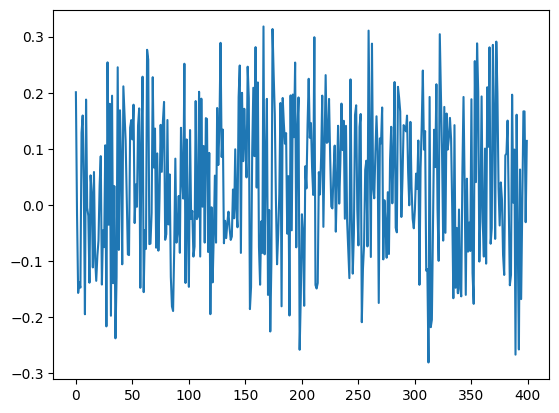

In [5]:
print(df_met0['kge'].max())
df_met0['kge'].plot()
plt.show()

# Check more iterations

In [17]:
dfall = pd.DataFrame()
dfn = []
for i in range(0, 5):
    dfi = pd.read_csv(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/MOASMO_exps/level1_221_exp2/ctsm_outputs_normKGE/iter{i}_many_metric.csv')
    dfn.append(dfi)
    dfall = pd.concat([dfall, dfi])
    if i == 0:
        print('defa', dfall['kge'].values[0])
    
    print(i, np.nanmax(dfall['kge'].values))
    

defa 0.2008636395138041
0 0.3181109467195373
1 0.3599686919482981
2 0.375900951394478
3 0.375900951394478
4 0.3795364042188088


# Parameter sensitivity

In [2]:
import pyviscous
df_param = pd.read_csv('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/MOASMO_exps/level1_221_exp2/ctsm_outputs_normKGE/iter0_all_meanparam.csv')
df_met0 = pd.read_csv('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/MOASMO_exps/level1_221_exp2/ctsm_outputs_normKGE/iter0_many_metric.csv')
param = df_param.values
met = df_met0['kge'].values

In [5]:
    nparam = param.shape[1]
    x = param
    y = met
    ind = ~np.isnan(y)
    x, y = x[ind,:], y[ind]
    y = y[:, np.newaxis]
    sens_indx_first = np.zeros(nparam)
    sens_indx_total = np.zeros(nparam)

    for xIndex in range(nparam): 
        sens_indx_first[xIndex], gmcm_first = pyviscous.viscous(x, y, xIndex, 'first', MSC='AIC', verbose=False) 
        sens_indx_total[xIndex], gmcm_total = pyviscous.viscous(x, y, xIndex, 'total', MSC='AIC', verbose=False)

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  5
    Sensitivity index = 0.055433
Calculating total-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.512853
Calculating first-order sensitivity index for variable index 1...
--- PART A: Data preparation
--- PART B: GMCM inference


/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: divide by zero encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)
/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: invalid value encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)
/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: divide by zero encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)
/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: invalid value encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas

	n_component=3, did not converge.


/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: divide by zero encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)
/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: invalid value encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)


--- PART C: Sensitivity index computation
    Best GMCM n_component =  2
    Sensitivity index = 0.042806
Calculating total-order sensitivity index for variable index 1...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.502887
Calculating first-order sensitivity index for variable index 2...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  3
    Sensitivity index = 0.018453
Calculating total-order sensitivity index for variable index 2...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.489728
Calculating first-order sensitivity index for variable index 3...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  2
    Sensitivity

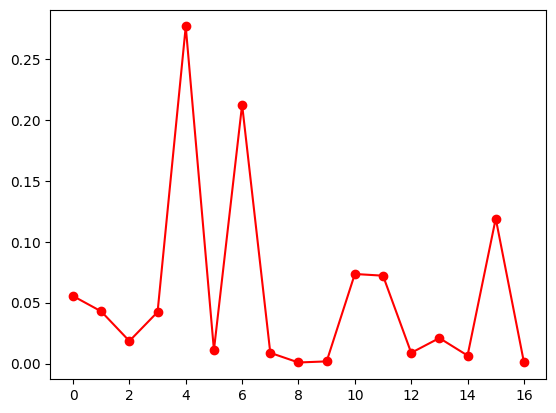

In [10]:
plt.plot(sens_indx_first, '-or')